In [2]:
import mdtraj as md

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#from itertools import product
#from scipy import stats

## Read trajs and colvars

### Read topology and select atoms of protein

In [10]:
basedir = '/home/vault/bcpc/bcpc001h/Photoswitches/b2AR_3PDS_UW58_Z_cysteine/metaD_multiple_walker_30_ns_30_bias_firtz_new_mdp_gromacs_2022_5_C10_rep_restr_1/'
topol_filename = f'{basedir}/trajectory/w0.gro'
walkers_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
trajectories_filenames = [f'{basedir}/trajectory/w{i}.xtc' for i in walkers_indices]
colvar_filenames = [f'{basedir}colvar/COLVAR.{i}' for i in walkers_indices]

In [3]:
# read topology
topology = md.load(topol_filename)

# if needed, print residue indices
if False:
  for i, res in enumerate(topology.top.residues):
    if i<290:
      print((i, res.name, res, res.resSeq, res.index))

## get indices of atoms in the protein
keep_atoms = []
for atom in topology.top.atoms:
  if atom.residue.index < 290:
    keep_atoms.append(atom.index)


In [4]:
print(f'protein atoms {len(keep_atoms)}')

protein atoms 4720


### Read trajectories (only protein atoms)

In [5]:
## read trajectories
trajectories = [md.load(trj_name, top = topology.top, atom_indices=keep_atoms) for trj_name in trajectories_filenames]

In [8]:
for trj in trajectories:
  print(trj)

# define top for protein only
top_proteinonly = trajectories[0].top

<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, and unitcells>
<mdtraj.Trajectory with 3601 frames, 4720 atoms, 290 residues, a

### Read original COLVARS

In [11]:
# read COLVARs
cols = ['time', 'd1.x', 'd1.y', 'd1.z', 's_cent', 'beta_cent',
       'wall_width', 'wall_buffer', 'lwall.bias', 'lwall.force2', 'uwall.bias',
       'uwall.force2', 'wall_center', 'wall_height', 'wall_steepness', 'dxy',
       'wall_bias', 'finalbias.bias', 'finalbias.wall_bias_bias', 'meta.bias',
       'meta.rbias', 'meta.rct']

original_cvs = []
for i, colvar_name in enumerate(colvar_filenames):
  cv = pd.read_csv(colvar_name, sep=" ", names=cols, skiprows=1, comment="#")
  cv_cleaned = cv.reset_index().drop(['index'],axis=1)
  original_cvs.append(cv_cleaned)
  max_time = max(cv_cleaned['time'])
  nrows = len(cv_cleaned)
  print(f'COLVAR file {i}: maxtime= {max_time}, nrows = {nrows}')


COLVAR file 0: maxtime= 360000.0, nrows = 360009
COLVAR file 1: maxtime= 360000.0, nrows = 360009
COLVAR file 2: maxtime= 360000.0, nrows = 360009
COLVAR file 3: maxtime= 360000.0, nrows = 360009
COLVAR file 4: maxtime= 360000.0, nrows = 360009
COLVAR file 5: maxtime= 360000.0, nrows = 360009
COLVAR file 6: maxtime= 360000.0, nrows = 360009
COLVAR file 7: maxtime= 360000.0, nrows = 360009
COLVAR file 8: maxtime= 360000.0, nrows = 360009
COLVAR file 9: maxtime= 360000.0, nrows = 360009
COLVAR file 10: maxtime= 360000.0, nrows = 360009
COLVAR file 11: maxtime= 360000.0, nrows = 360009
COLVAR file 12: maxtime= 360000.0, nrows = 360009
COLVAR file 13: maxtime= 360000.0, nrows = 360009
COLVAR file 14: maxtime= 360000.0, nrows = 360009
COLVAR file 15: maxtime= 360000.0, nrows = 360009
COLVAR file 16: maxtime= 360000.0, nrows = 360009
COLVAR file 17: maxtime= 360000.0, nrows = 360009
COLVAR file 18: maxtime= 360000.0, nrows = 360009
COLVAR file 19: maxtime= 360000.0, nrows = 360009
COLVAR fil

## Calculate colvars

### recalc original colvars (distance)

In [12]:
## calculate original cvs
# c1: CENTER ATOMS=3743,1455 # center 233Trp-90Val
# d1: DISTANCE ATOMS=c1,1076 COMPONENTS # c1 70MOL C10

## check we have the right atoms
for i in [3743, 1455, 1076]:
    atom = top_proteinonly.atom(i-1)
    print((i, atom.residue, atom.name))

(3743, TRP233, 'CA')
(1455, VAL90, 'CA')
(1076, MOL70, 'C10')


In [13]:
## be careful to subtract one as atom numbers in gro/plumed start from 1 and in mdtraj start from 0

def recalculate_cv(traj):
 at1 = traj.xyz[:, 3743-1, :]
 at2 = traj.xyz[:, 1455-1, :]
 at3 = traj.xyz[:, 1076-1, :]
 com = (at1 + at2)/2
 vect = at3 - com

 # original colvar has times in ps,
 # here we have 10 frames/ns, i.e. row index * 100 is time in ps
 times = [t*100 for t in range(vect.shape[0])]

 df = pd.DataFrame(vect, columns=['d1.x','d1.y','d1.z'])
 df['time'] = times

 return df

In [14]:
recalc_cvs = [recalculate_cv(trj) for trj in trajectories]

/home/hpc/bcpc/bcpc001h/miniforge3/envs/MDtraj_py311/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/hpc/bcpc/bcpc001h/miniforge3/envs/MDtraj_py311/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


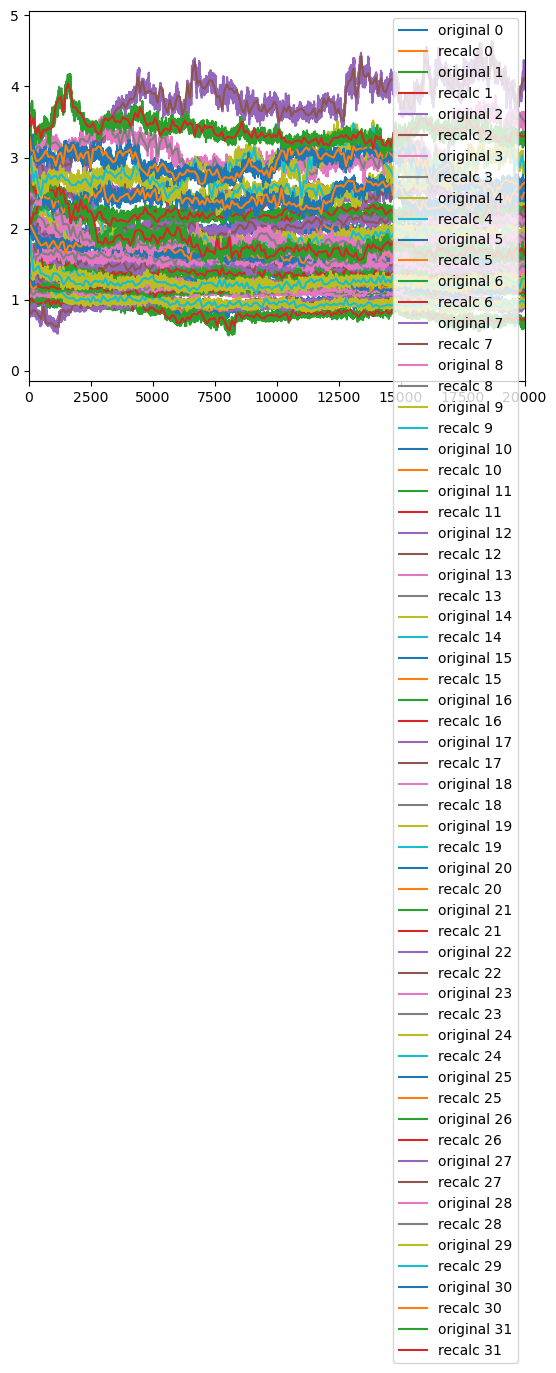

In [15]:
for i in range(len(walkers_indices)):
  plt.plot(original_cvs[i]['time'], original_cvs[i]['d1.z'],label=f'original {i}')
  plt.plot(recalc_cvs[i]['time'],recalc_cvs[i]['d1.z'],label=f'recalc {i}')
  plt.legend()
  plt.xlim(0,20000)

In [16]:
## stride original to get only the points we have in the recalculated
original_cvs_strided_withduplicates = [ocv.loc[ ( ocv['time'] % 100 == 0 )] for ocv in original_cvs]
original_cvs_strided = [ocv.drop_duplicates(['time']) for ocv in original_cvs_strided_withduplicates]



In [17]:
original_cvs_strided[0].columns

Index(['time', 'd1.x', 'd1.y', 'd1.z', 's_cent', 'beta_cent', 'wall_width',
       'wall_buffer', 'lwall.bias', 'lwall.force2', 'uwall.bias',
       'uwall.force2', 'wall_center', 'wall_height', 'wall_steepness', 'dxy',
       'wall_bias', 'finalbias.bias', 'finalbias.wall_bias_bias', 'meta.bias',
       'meta.rbias', 'meta.rct'],
      dtype='object')

In [18]:
#rct is the the reweighting factor c(t)
#rbis the instantaneous value of the bias normalized using the c(t) reweighting factor [rbias=bias-rct].This component can be used to obtain a reweighted histogram


### Calculate new CVS coordination between ligand and protein

We calculate the minimum distances between the ligand and residues (heavy atoms) and apply the switching function with a $r_0=0.4~nm$

In [19]:
## identify residue index for the ligand
atom_in_ligand = top_proteinonly.atom(1076-1)
ligand_residue_index = atom_in_ligand.residue.index
print(ligand_residue_index)

69


In [20]:
# compute_contacts calculates the distances between residues
# manual entry for compute_contacts
# https://mdtraj.org/1.9.3/api/generated/mdtraj.compute_contacts.html

In [21]:
group1 = [ligand_residue_index]
group2 = [res.index for res in top_proteinonly.residues if not res.index==ligand_residue_index]
pairs = [[res1,res2] for res1 in group1 for res2 in group2]

def switch(distance, r0=0.4,n=10, m=20):
  rho = (distance/r0)
  return (1-rho**n)/(1-rho**m)

contacts = []
for traj in trajectories:
  ## the first element is an array with all the distances, the second is the residue pairs
  mindistances, respairs = md.compute_contacts(traj, contacts=pairs, scheme='closest-heavy')

  ## contacts = np.sum(1*mindistances<0.4,axis=1)
  contact_count = np.sum(switch(mindistances),axis=1)
  # original colvar has times in ps,
  # here we have 10 frames/ns, i.e. row index * 100 is time in ps
  times = [t*100 for t in range(contact_count.shape[0])]

  contact_count_df = pd.DataFrame(contact_count, columns=['contact_count'])
  contact_count_df['time']=times
  contacts.append(contact_count_df)


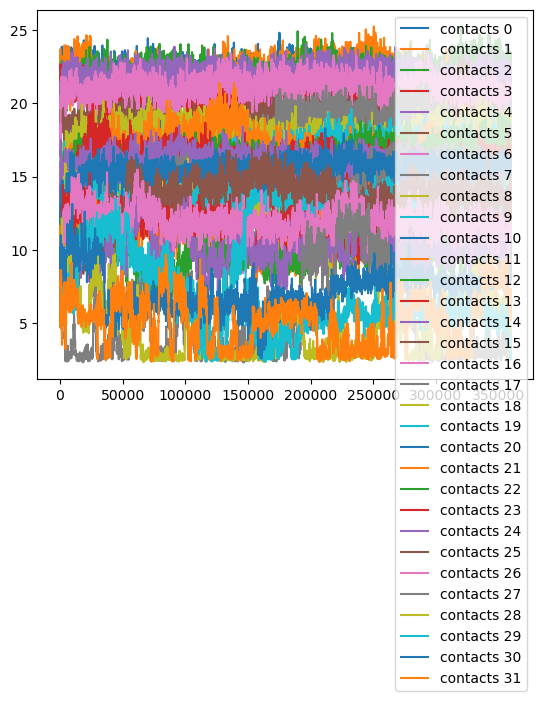

In [22]:
for i in range(len(walkers_indices)):
  plt.plot(contacts[i]['time'],contacts[i]['contact_count'],label=f'contacts {i}')
  plt.legend()

### Calculate new CV: protein-ligand + ligand-ligand 2d embedding and clustering

In [23]:
## fragment definition for ligand
fragments_long = {
    'Benzoxazinone': [('C1',  1086), ('C2',  1085), ('C3',  1089), ('C4',  1083), ('O1',  1087), ('O2',  1084), ('N1',  1088)],
    'Benyzl': [('C5',  1082), ('C32', 1092), ('C33', 1091), ('C34', 1090), ('O6',  1095)],
    'Phenyl': [('C10',1076), ('C11', 1075), ('C12', 1074), ('C13', 1073), ('C30', 1112), ('C31', 1111)],
    'Pyrazol': [ ('C14', 1070), ('C15', 1069), ('C16', 1123), ('N5' , 1068), ('N8' , 1118), ('C28', 1117), ('C29', 1119) ],
    'Disulfide': [ ('C21', 1063), ('S1' , 1062), ('S2' , 1061), ('C22', 1060)] }

## I think a list is better, since the order matters; we consider element 0 to be covalently bound to 1, 1 to 0 and 2, etc.
long_names = ['Benzoxazinone', 'Benyzl','Phenyl', 'Pyrazol', 'Disulfide']
name_shorten = {'Benzoxazinone':'BNXA', 'Benyzl':'BYL','Phenyl':'PYL', 'Pyrazol':'PYR', 'Disulfide':'DSF'}
short_names = [name_shorten[k] for k in long_names]

fragments = [ [at[1] for at in fragments_long[key]] for key in long_names]
fraglist = [i for i in range(len(fragments))]
fragpairs = [[fr1,fr2] for fr1 in fraglist for fr2 in fraglist if fr2-fr1>1]


In [24]:
## to calculate the contacts between fragments, we cannot use the `compute_contacts` becuase it's based on residues

def compute_contacts_fragments(traj_, fragments_, fragpairs_):
  '''
  fragments = list of lists of atoms
  '''

  # define the pairs of atoms that we need
  fraglist = [i for i in range(len(fragments_))]
  pairs = []
  groups = []
  for fragpair in fragpairs_:
    fr1,fr2=fragpair
    for at1 in fragments_[fr1]:
      for at2 in fragments_[fr2]:
        pairs.append([at1,at2])
        groups.append(fragpair)

  distances = md.compute_distances(traj, pairs)
  groupids = np.unique(groups,axis=0).tolist()

  mindists=[]
  for group in groupids:
    #print(group)
    cols = np.array([p==group for p in groups])
    #print(len(cols))
    group_distances = distances[:,cols]
    group_mindist = np.min(group_distances,axis=1)
    mindists.append(group_mindist)

  mindistances = np.vstack(mindists).transpose()
  #print(mindistances.shape)
  return mindistances, groupids


In [25]:
## label for protein-ligand-contacts
def get_pair_label(pair):
  res1 =  top_proteinonly.residue(pair[0]).__str__()
  res2 =  top_proteinonly.residue(pair[1]).__str__()
  return f'cmap:{res1}-{res2}'

pair_labels = [get_pair_label(pair) for pair in pairs]

## labels for fragment contacts
def get_fragment_label(pair):
  frg1 = short_names[pair[0]]
  frg2 = short_names[pair[1]]
  return f'fmap:{frg1}-{frg2}'

fragpair_labels = [get_fragment_label(pair) for pair in fragpairs]


In [26]:
cmap = []
for traj in trajectories:

  ## residue-resiude distance
  ## the first element is an array with all the distances, the second is the residue pairs
  mindistances, respairs = md.compute_contacts(traj, contacts=pairs, scheme='closest-heavy')
  ctscontacts = switch(mindistances)

  ## frag-frag-distance
  fragdistances, fragpair_ids = compute_contacts_fragments(traj, fragments, fragpairs)
  frgcontacts = switch(fragdistances)

  allcontacts = np.hstack([ctscontacts,frgcontacts])
  all_labels = pair_labels + fragpair_labels
  times = [t*100 for t in range(contact_count.shape[0])]

  cmap_df = pd.DataFrame(allcontacts, columns=all_labels)
  cmap_df['time']=times
  cmap.append(cmap_df)

In [27]:
cmap_concat = pd.concat(cmap)
cmap_concat.head()

,cmap:MOL70-ACE1,cmap:MOL70-ASP2,cmap:MOL70-GLU3,cmap:MOL70-VAL4,cmap:MOL70-TRP5,cmap:MOL70-VAL6,cmap:MOL70-VAL7,cmap:MOL70-GLY8,cmap:MOL70-MET9,cmap:MOL70-GLY10,...,cmap:MOL70-CYS288,cmap:MOL70-LEU289,cmap:MOL70-NME290,fmap:BNXA-PYL,fmap:BNXA-PYR,fmap:BNXA-DSF,fmap:BYL-PYR,fmap:BYL-DSF,fmap:PYL-DSF,time
0,8.085836e-07,0.000005,0.000003,0.000003,0.002469,0.001002,0.000020,0.000004,0.000126,0.000025,...,4.519415e-10,3.332780e-10,1.024740e-10,0.044806,0.000237,0.000002,0.000107,9.350341e-07,0.000329,0
1,8.541803e-07,0.000005,0.000004,0.000003,0.002707,0.000670,0.000010,0.000002,0.000060,0.000019,...,4.499955e-10,6.191547e-10,1.246211e-10,0.041181,0.000255,0.000002,0.000076,1.091316e-06,0.000864,100
2,1.173924e-06,0.000009,0.000009,0.000004,0.001640,0.001299,0.000015,0.000004,0.000146,0.000023,...,4.603270e-10,6.187093e-10,1.612768e-10,0.050606,0.000429,0.000002,0.000135,9.684862e-07,0.000416,200
3,1.152891e-06,0.000011,0.000011,0.000005,0.003620,0.004163,0.000029,0.000005,0.000069,0.000033,...,4.666442e-10,5.187756e-10,1.218093e-10,0.032808,0.000187,0.000002,0.000060,7.627392e-07,0.000616,300
4,1.151069e-06,0.000008,0.000011,0.000004,0.001315,0.001169,0.000016,0.000004,0.000155,0.000022,...,4.812571e-10,7.686488e-10,1.523962e-10,0.035980,0.000367,0.000002,0.000110,8.252629e-07,0.000354,400


In [3]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

embedding = PCA(n_components=2, svd_solver='full')
X_transformed = embedding.fit_transform(cmap_concat.drop(['time'], axis=1).values)

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
X_clusters = kmeans.fit(cmap_concat.drop(['time'], axis=1).values)
cluster_labels = X_clusters.labels_

NameError: name 'cmap_concat' is not defined

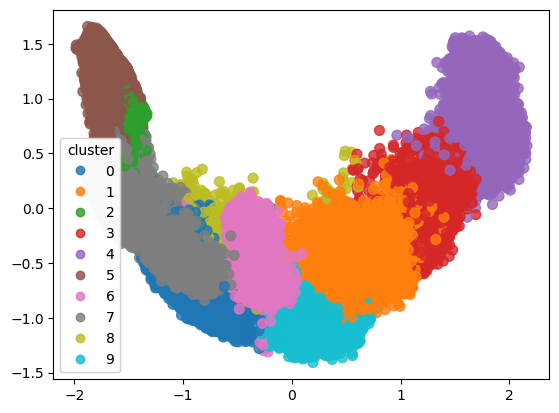

In [29]:
fig, ax = plt.subplots()
col = ax.scatter(X_transformed[:,0], X_transformed[:,1],  c=cluster_labels, s=50, alpha=0.8, cmap='tab10')
legend1 = ax.legend(*col.legend_elements(),loc="lower left", title="cluster")
ax.add_artist(legend1)


In [30]:
res_clusters = []
for cmap_df in cmap:
    contact_values = cmap_df.drop(['time'], axis=1).values
    x_embed = embedding.transform(contact_values)
    labels_embed = [f'pca_{dim}' for dim in range(x_embed.shape[1])]
    clusters = kmeans.predict(contact_values)
    res_df = pd.DataFrame(x_embed, columns=labels_embed)
    res_df['cluster_id'] = clusters
    res_df['time']=cmap_df['time']

    df1 = cmap_df.set_index(['time'])
    df2 = res_df.set_index(['time'])
    join1 = df1.join(df2)
    res_clusters.append(join1)


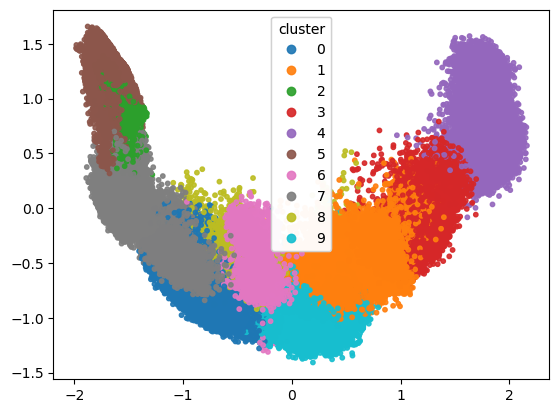

In [31]:
clus_concat = pd.concat(res_clusters)
fig, ax = plt.subplots()
col = ax.scatter(clus_concat['pca_0'], clus_concat['pca_1'],
                 c=clus_concat['cluster_id'], s=10, alpha=0.9, cmap='tab10')
legend1 = ax.legend(*col.legend_elements(), title="cluster")
ax.add_artist(legend1)



#### identify contacts in each cluster (not reweighed!)

In [32]:
contact_means_byclust = clus_concat.groupby('cluster_id').agg('mean').reset_index()
cmap_cols = [colname for colname in contact_means_byclust.columns if "cmap:" in colname]
fmap_cols = [colname for colname in contact_means_byclust.columns if "fmap:" in colname]

## calculate sum of contacts, this should be the same as the contact_count CV calculated before
contact_means_byclust['cmap_sum'] = contact_means_byclust[cmap_cols].sum(axis=1)
contact_means_byclust['fmap_sum'] = contact_means_byclust[fmap_cols].sum(axis=1)

formed_contacts = contact_means_byclust[cmap_cols+fmap_cols].max()>.5
contacts_bycluster = contact_means_byclust[formed_contacts.index[formed_contacts]]

In [33]:
contact_means_byclust[['cluster_id','pca_0','pca_1','cmap_sum','fmap_sum']]

,cluster_id,pca_0,pca_1,cmap_sum,fmap_sum
0,0,-0.828114,-0.705646,12.017159,0.909170
1,1,0.579011,-0.486458,16.000166,0.761812
2,2,-1.535632,0.885131,6.784698,1.541023
3,3,1.143134,-0.156369,18.467880,0.083784
4,4,1.803330,0.755650,21.612577,0.129180
5,5,-1.648820,1.270478,4.951120,1.224306
6,6,-0.315987,-0.558136,14.428068,0.492684
7,7,-1.351167,-0.049534,10.528120,1.202554
8,8,-0.445896,-0.480815,13.102572,0.607536
9,9,0.216656,-1.032109,15.808058,0.429959


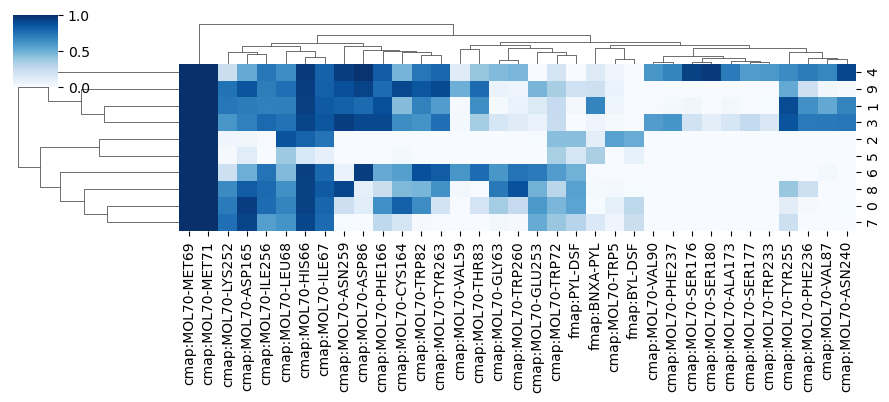

In [34]:
from seaborn import clustermap
g=clustermap(contacts_bycluster, figsize=(9,4), cmap="Blues", vmin=0, vmax=1)
#g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)

## Reweigh

### Join dataframes with old CVs, new CVs, and reweigh factors

In [35]:
## check that for all walkers the old and new dataframes have the same number of rows
for i in range(len(walkers_indices)):
  print((i, len(original_cvs_strided[i]), len(recalc_cvs[i]), len(contacts[i]), len(res_clusters[i])))


(0, 3601, 3601, 3601, 3601)
(1, 3601, 3601, 3601, 3601)
(2, 3601, 3601, 3601, 3601)
(3, 3601, 3601, 3601, 3601)
(4, 3601, 3601, 3601, 3601)
(5, 3601, 3601, 3601, 3601)
(6, 3601, 3601, 3601, 3601)
(7, 3601, 3601, 3601, 3601)
(8, 3601, 3601, 3601, 3601)
(9, 3601, 3601, 3601, 3601)
(10, 3601, 3601, 3601, 3601)
(11, 3601, 3601, 3601, 3601)
(12, 3601, 3601, 3601, 3601)
(13, 3601, 3601, 3601, 3601)
(14, 3601, 3601, 3601, 3601)
(15, 3601, 3601, 3601, 3601)
(16, 3601, 3601, 3601, 3601)
(17, 3601, 3601, 3601, 3601)
(18, 3601, 3601, 3601, 3601)
(19, 3601, 3601, 3601, 3601)
(20, 3601, 3601, 3601, 3601)
(21, 3601, 3601, 3601, 3601)
(22, 3601, 3601, 3601, 3601)
(23, 3601, 3601, 3601, 3601)
(24, 3601, 3601, 3601, 3601)
(25, 3601, 3601, 3601, 3601)
(26, 3601, 3601, 3601, 3601)
(27, 3601, 3601, 3601, 3601)
(28, 3601, 3601, 3601, 3601)
(29, 3601, 3601, 3601, 3601)
(30, 3601, 3601, 3601, 3601)
(31, 3601, 3601, 3601, 3601)


In [36]:

## join original cvs (which also contains the reweigh factor), the recalculated cvs, and the new cvs

joined_cvs = []

for i in range(len(walkers_indices)):

  original_setindex = original_cvs_strided[i].set_index(['time'])
  recalc_setindex = recalc_cvs[i].set_index(['time'])
  newcvs_setindex = contacts[i].set_index(['time'])
  res_clusters_setindex = res_clusters[i]

  res_clusters_setindex['delta_pca_0'] = np.append(res_clusters[i]['pca_0'][1:].values -res_clusters[i]['pca_0'][:-1].values,np.nan)
  res_clusters_setindex['delta_pca_1'] = np.append(res_clusters[i]['pca_1'][1:].values -res_clusters[i]['pca_1'][:-1].values,np.nan)

  join1 = original_setindex.join(recalc_setindex , rsuffix='recalc')
  join2 = join1.join(newcvs_setindex)
  join3 = join2.join(res_clusters_setindex)

  join3['walker_index'] = walkers_indices[i]

  joined_cvs.append(join3)

### calculate weights

In [38]:
## first concatenate all walters into a single dataframe

joined_cvs_concat = pd.concat(joined_cvs)
joined_cvs_concat.head()

joined_cvs_concat.to_csv(r'/home/vault/bcpc/bcpc001h/Photoswitches/b2AR_3PDS_UW58_Z_cysteine/metaD_multiple_walker_30_ns_30_bias_firtz_new_mdp_gromacs_2022_5_C10_rep_restr_1/clustering/joined_cvs_contact.csv')

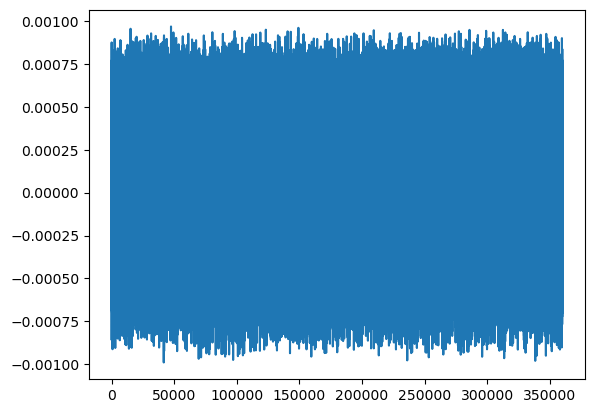

In [39]:
plt.plot(joined_cvs_concat['d1.z']-joined_cvs_concat['d1.zrecalc'])

In [40]:
## calculate weights from rbias
weight_nonnorm = np.exp(joined_cvs_concat['meta.rbias'].values)
joined_cvs_concat['weight'] = weight_nonnorm/np.sum(weight_nonnorm)

#### cluster population by trajectory

In [41]:
cluster_weights_trj = joined_cvs_concat.groupby(['walker_index','cluster_id']).agg({'weight':'count'}).reset_index()
cluster_weights_trj.pivot(index='walker_index',columns='cluster_id',values='weight')

cluster_id,0,1,2,3,4,5,6,7,8,9
walker_index,,,,,,,,,,
0,NaN,NaN,NaN,NaN,3601.0,NaN,NaN,NaN,NaN,NaN
1,NaN,12.0,NaN,45.0,3399.0,NaN,NaN,NaN,139.0,6.0
2,NaN,NaN,NaN,NaN,3601.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,3600.0,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,NaN,9.0,3591.0,NaN,NaN,NaN,NaN,NaN
5,NaN,99.0,NaN,3466.0,36.0,NaN,NaN,NaN,NaN,NaN
6,NaN,2.0,NaN,2.0,3597.0,NaN,NaN,NaN,NaN,NaN
7,NaN,1208.0,NaN,2377.0,16.0,NaN,NaN,NaN,NaN,NaN
8,NaN,96.0,NaN,3505.0,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
cluster_weights = joined_cvs_concat.groupby(['cluster_id']).agg({'weight':'sum'}).reset_index()
#cluster_weights.pivot(index='walker_index',columns='cluster_id',values='weight')
cluster_weights['fes'] = -np.log(cluster_weights['weight'])
cluster_weights

,cluster_id,weight,fes
0,0,1.049216e-04,9.162297
1,1,3.187428e-01,1.143371
2,2,2.892815e-06,12.753280
3,3,5.036035e-01,0.685966
4,4,1.771822e-01,1.730576
5,5,5.724241e-07,14.373386
6,6,8.687820e-05,9.351003
7,7,6.170372e-05,9.693166
8,8,1.036026e-05,11.477533
9,9,2.041496e-04,8.496658


### plot as a function of old cv d1z

In [43]:
## do histogram on old cvs
joined_cvs_concat['bins_d1z'] = round(joined_cvs_concat['d1.z'],2)
fes1=joined_cvs_concat.groupby('bins_d1z').agg({'weight':'sum'}).reset_index()
fes1['fes'] = -np.log(fes1['weight'])

Text(0, 0.5, 'fes (kT)')

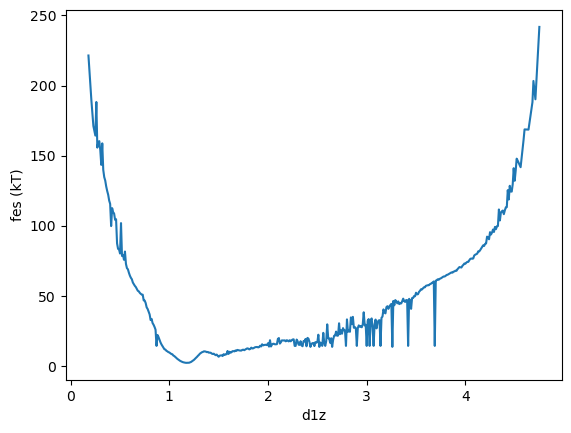

In [44]:
plt.plot(fes1['bins_d1z'],fes1['fes'])
plt.xlabel('d1z')
plt.ylabel('fes (kT)')

### plot as a function of contact map

In [45]:
## do histogram on new cvs
joined_cvs_concat['bins_contacts'] = round(joined_cvs_concat['contact_count'],0)
fes2=joined_cvs_concat.groupby('bins_contacts').agg({'weight':'sum'}).reset_index()
fes2['fes'] = -np.log(fes2['weight'])

Text(0, 0.5, 'fes (kT)')

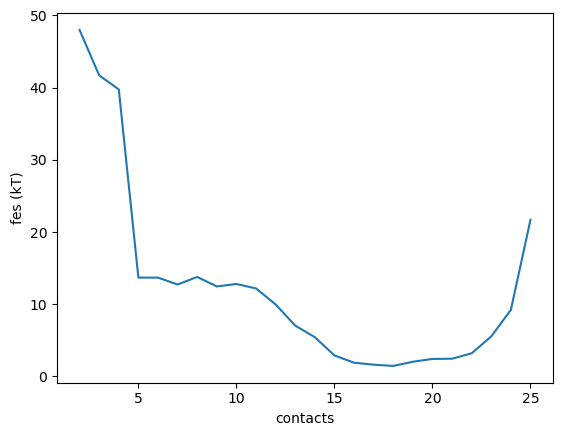

In [46]:
plt.plot(fes2['bins_contacts'],fes2['fes'])
plt.xlabel('contacts')
plt.ylabel('fes (kT)')

### plot 2d free-energy

In [47]:
## do histogram on new cvs
joined_cvs_concat['bins_contacts'] = round(joined_cvs_concat['contact_count'],0)
fes3=joined_cvs_concat.groupby(['bins_d1z','bins_contacts']).agg({'weight':'sum'}).reset_index()
fes3['fes'] = -np.log(fes3['weight'])


In [141]:
# double check that integrating one dimension we get the correct result
#fes3c = fes3.groupby(['bins_contacts']).agg({'weight':'sum'}).reset_index()
#fes3c['fes'] = -np.log(fes3c['weight'])
#plt.plot(fes3c['bins_contacts'],fes3c['fes'])
#plt.xlabel('contacts')
#plt.ylabel('fes (kT)')

Text(0, 0.5, 'contacts')

<Figure size 700x200 with 0 Axes>

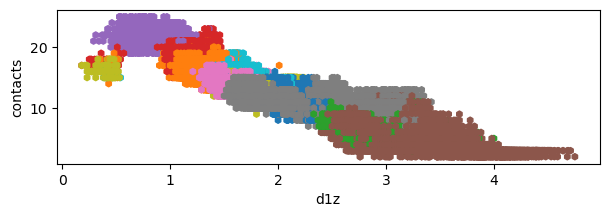

In [48]:
plt.figure(figsize=(7,2))
fig, ax = plt.subplots(figsize=(7,2))
im = plt.scatter(joined_cvs_concat['bins_d1z'],
                 joined_cvs_concat['bins_contacts'], marker="h", s=20,
                 c=joined_cvs_concat['cluster_id'], cmap='tab10')

legend1 = ax.legend(*im.legend_elements(), title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left', bbox_transform=plt.gcf().transFigure)
ax.add_artist(legend1)

plt.xlabel('d1z')
plt.ylabel('contacts')


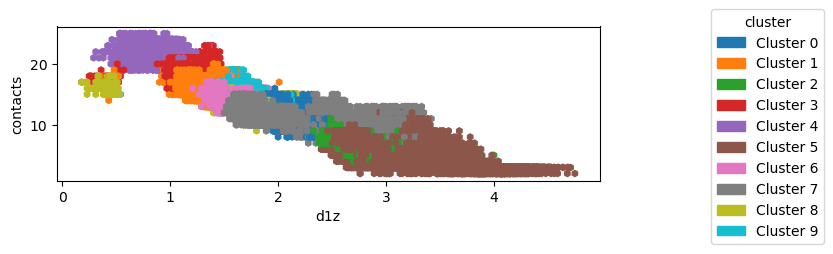

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(7,2))
im = ax.scatter(joined_cvs_concat['bins_d1z'],
                joined_cvs_concat['bins_contacts'], marker="h", s=20,
                c=joined_cvs_concat['cluster_id'], cmap='tab10')

# Create custom legend
handles = [mpatches.Patch(color=plt.cm.tab10(i), label=f'Cluster {i}') for i in range(10)]
ax.legend(handles=handles, title="cluster", bbox_to_anchor=(1.05, 1), loc='upper left', bbox_transform=plt.gcf().transFigure)

plt.xlabel('d1z')
plt.ylabel('contacts')

plt.show()


Text(0, 0.5, 'contacts')

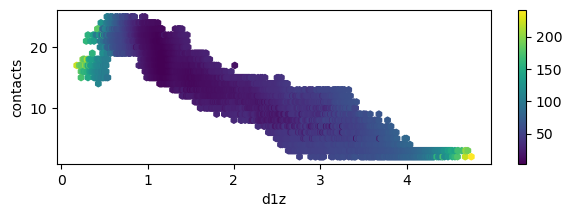

In [50]:
plt.figure(figsize=(7,2))
im = plt.scatter(fes3['bins_d1z'],fes3['bins_contacts'], marker="h", s=20, c=fes3['fes'], cmap=None)
plt.colorbar(im)
plt.xlabel('d1z')
plt.ylabel('contacts')

In [51]:
## do histogram on new cvs
joined_cvs_concat['bins_pca_0'] = round(joined_cvs_concat['pca_0'],2)
joined_cvs_concat['bins_pca_1'] = round(joined_cvs_concat['pca_1'],2)

fes4=joined_cvs_concat.groupby(['bins_pca_0','bins_pca_1']).agg({'weight':'sum'}).reset_index()
fes4['fes'] = -np.log(fes4['weight'])


Text(0, 0.5, 'bins_pca_1')

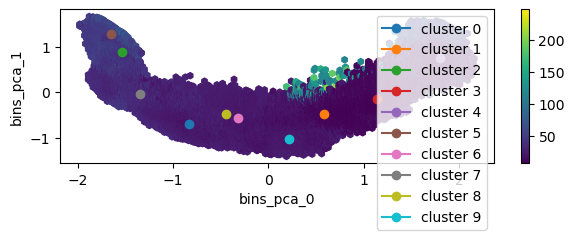

In [52]:
plt.figure(figsize=(7,2))
im = plt.scatter(fes4['bins_pca_0'],fes4['bins_pca_1'], marker="h", s=20, c=fes4['fes'], cmap=None)
plt.colorbar(im)

clcenters = contact_means_byclust[['cluster_id','pca_0','pca_1']]

for clI in clcenters['cluster_id']:
    plt.plot(clcenters[clcenters['cluster_id']==clI]['pca_0'],
             clcenters[clcenters['cluster_id']==clI]['pca_1'],
             marker='o', label=f'cluster {clI}')
    

# Move the legend outside the box
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.legend()
plt.xlabel('bins_pca_0')
plt.ylabel('bins_pca_1')

Text(0, 0.5, 'bins_pca_1')

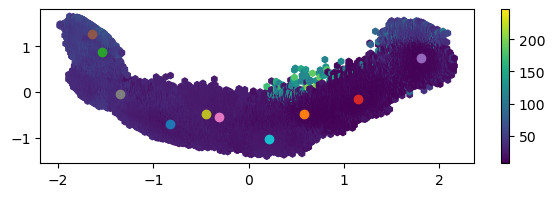

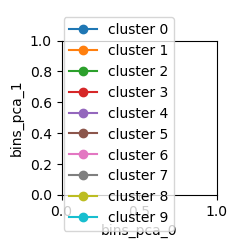

In [53]:
plt.figure(figsize=(7,2))
im = plt.scatter(fes4['bins_pca_0'],fes4['bins_pca_1'], marker="h", s=20, c=fes4['fes'], cmap=None)
plt.colorbar(im)

clcenters = contact_means_byclust[['cluster_id','pca_0','pca_1']]

for clI in clcenters['cluster_id']:
    plt.plot(clcenters[clcenters['cluster_id']==clI]['pca_0'],
             clcenters[clcenters['cluster_id']==clI]['pca_1'],
             marker='o', label=f'cluster {clI}')

# Create a separate legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
fig_legend = plt.figure(figsize=(2,2))
fig_legend.legend(handles, labels, loc='center')
fig_legend.canvas.draw()

plt.xlabel('bins_pca_0')
plt.ylabel('bins_pca_1')


#### Save trajs

In [1]:
frames_per_walker = 10
basedir = '/home/vault/bcpc/bcpc001h/Photoswitches/b2AR_3PDS_UW58_Z_cysteine/metaD_multiple_walker_30_ns_30_bias_firtz_new_mdp_gromacs_2022_5_C10_rep_restr_1/clustering/'
clusterIDs = np.unique(clus_concat['cluster_id'])
for clID in clusterIDs:
  print(f'\nExtracting frames for cluster {clID}')
  cluster_traj_extracted = []
  for trj_index, trj in enumerate(trajectories):
    #print((clID, trj_index))
    cdata = res_clusters[trj_index]
    cdata_nrows = len(cdata)
    nframes = trj.n_frames
    frames_cluster = np.where(cdata['cluster_id']==clID)[0]
    print(f'clID={clID}, trj={trj_index} nframes={nframes}, cdata_nrows={cdata_nrows}, frames={len(frames_cluster)}')
    if len(frames_cluster)>0:
      ## randomise frames_per_walker
      frames_per_walker_safe = np.min([len(frames_cluster), frames_per_walker])
      keep_frames_cluster = np.random.choice(frames_cluster, frames_per_walker_safe, replace=False)
      cluster_traj_extracted.append(trj[keep_frames_cluster])
  res_trj = md.join(cluster_traj_extracted)
  filename = f'{basedir}/cluster_cl_{clID}.dcd'
  res_trj_whole = res_trj.image_molecules()
  res_trj_whole.save_dcd(filename)
  res_trj_whole[0].save_pdb(f'{basedir}/cluster_cl_{clID}.pdb')
  print(f'{res_trj.n_frames} frames saved in {filename}')



NameError: name 'np' is not defined

### Study kinetics


### calculate reweighted averages

We follow the MetaD + MaxCal approach we used in [this paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6291190/)

In [101]:
# prepare microstates based on bins

def get_fes(cvs,cvs_names,prec):
   bin_vals = []
   fes = cvs.copy()
   for i, cv in enumerate(cvs_names):
      fes[f'bin_{cv}'] = round(cvs[cv]/prec,0)*prec
      ucv  = np.unique(fes[f'bin_{cv}'])
      print(f'cv_{i}->{cv} has {len(ucv)} values')
      bin_vals.append(ucv)

   print(f'number of microstates')
   bin_vals_mins = [min(bv/prec) for bv in bin_vals]
   bin_vals_len = [len(bv) for bv in bin_vals]
   for i, cv in enumerate(cvs_names):
      fes[f'binID_{cv}'] = (fes[f'bin_{cv}']/prec-bin_vals_mins[i]).astype(int)

   microst = []
   for index, row in fes.iterrows():
       microst.append( row['binID_pca_0']*bin_vals_len[1] + row['binID_pca_1'] )


   fes['micro_1d_FULL'] = np.array(microst).astype(int)
   fes['jump_n'] = np.append(np.array(microst)[1:] -np.array(microst)[:-1],np.nan)
   fes['jump'] = 1*(np.abs(fes['jump_n'])>0)

   tot_micro = np.prod([len(cvv) for cvv in bin_vals])
   pop_micro = len(np.unique(microst))
   print(f'{pop_micro} populated states out of {tot_micro}')
   micros = pd.DataFrame({'micro_1d_FULL':np.unique(microst).astype(int)})
   micros['micro_1d_SHORT'] = micros.index
   micros['id1'] = micros['micro_1d_FULL'] % bin_vals_len[1]
   micros['id0'] = ((micros['micro_1d_FULL'] - micros['id1'])/bin_vals_len[1]).astype(int)
   micros['val0'] = np.array(bin_vals[0])[micros['id0']]
   micros['val1'] = np.array(bin_vals[1])[micros['id1']]



   fes = fes.merge(micros, left_on='micro_1d_FULL', right_on= 'micro_1d_FULL', how='left')

   return fes,bin_vals,micros


#fes4=joined_cvs_concat.groupby(['bins_pca_0','bins_pca_1']).agg({'weight':'sum'}).reset_index()
#fes4['fes'] = -np.log(fes4['weight'])


fesX,bin_vals,micros = get_fes(joined_cvs_concat, ['pca_0','pca_1'],.2)

cv_0->pca_0 has 22 values
cv_1->pca_1 has 16 values
number of microstates
191 populated states out of 352


In [102]:
## get the cluster to which each bin belongs for (using the cluster most populates in each bin)
fesY = fesX.groupby(['micro_1d_FULL', 'micro_1d_SHORT','cluster_id']).size().reset_index()
idx = fesY.groupby(['micro_1d_FULL', 'micro_1d_SHORT'])[0].transform(max) == fesY[0]
bin2cluster = fesY[idx].groupby(['micro_1d_FULL', 'micro_1d_SHORT']).agg(min).reset_index()

/tmp/ipykernel_134344/4283794053.py:3: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = fesY.groupby(['micro_1d_FULL', 'micro_1d_SHORT'])[0].transform(max) == fesY[0]
/tmp/ipykernel_134344/4283794053.py:4: FutureWarning: The provided callable <built-in function min> is currently using DataFrameGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  bin2cluster = fesY[idx].groupby(['micro_1d_FULL', 'micro_1d_SHORT']).agg(min).reset_index()


In [103]:
micro2clusters = [ bin2cluster[bin2cluster['cluster_id']==i]['micro_1d_SHORT'].values for i in np.unique(bin2cluster['cluster_id']) ]
micro2clusters


[array([25, 35, 36, 42, 43, 44, 46, 50, 51, 52, 53, 54, 55, 59, 60, 61, 67,
        68]),
 array([ 86,  87,  88,  89,  90,  94,  95,  96,  97,  98, 103, 104, 105,
        106, 115, 116, 117, 118, 122, 123, 124, 125, 126, 128, 132, 133,
        140]),
 array([20, 32]),
 array([119, 120, 127, 129, 130, 131, 134, 135, 136, 137, 138, 139, 141,
        142, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 162,
        163]),
 array([148, 149, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190]),
 array([ 0,  1,  2,  3,  8,  9, 10, 11, 12, 13, 21, 22, 23, 24, 33, 34]),
 array([72, 73, 75, 78, 79, 80, 81, 82]),
 array([ 4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 26, 27, 28, 29, 30, 31, 37,
        38, 39, 40, 41, 45, 47]),
 array([ 48,  49,  56,  57,  58,  62,  63,  64,  65,  66,  69,  70,  71,
         74,  99, 107, 108, 109, 110, 121]),
 array([ 76,  77,  83,  8

In [104]:
if False:
  for f in fesX.columns:
    if not 'cmap'  in f and not 'fmap'  in f:
      print(f)

In [105]:
## calulate averages for constrains for MaxCal
deltaT = 0.01
rconts0 = deltaT*np.sum(np.abs(fesX['delta_pca_0'])*fesX['weight'])
rconts1 = deltaT*np.sum(np.abs(fesX['delta_pca_1'])*fesX['weight'])
jconts = deltaT*np.sum(np.abs(fesX['jump'])*fesX['weight'])
rconts = [rconts0, rconts1,jconts]
print(rconts)

[0.001036590368798618, 0.0011758541946861835, 0.007528782674033018]


In [106]:
# calculate stationary probabilities
fesX2=fesX.groupby(['micro_1d_FULL', 'micro_1d_SHORT', 'id1', 'id0']).agg({'weight':'sum'}).reset_index()
fesX2['q0'] = -np.log(fesX2['weight'])
fesX2['p0'] = fesX2['q0']/np.sum(fesX2['q0'])
p0 = fesX2['p0'].values

In [107]:
## Define matrices corresponing to the constraints for MaxCal

ndim = len(micros['val0'])
R0 = np.abs(np.add.outer(micros['val0'].values, - micros['val0'].values))
R1 = np.abs(np.add.outer(micros['val1'].values, - micros['val1'].values))
Jump = (1-np.diag([1]*ndim))
Adj = 1*np.logical_or(
    np.abs(np.add.outer(micros['id0'].values, - micros['id0'].values))<2,
    np.abs(np.add.outer(micros['id1'].values, - micros['id1'].values))<2)

In [108]:
def tmat_instant(pi0):
  return  np.repeat(pi0, repeats=len(pi0)). reshape((len(pi0),len(pi0))).transpose()

def get_probs(tmat):
  tmat2 = tmat.transpose()
  eigenvalues, eigenvectors = np.linalg.eig(tmat2)
  #print(eigenvalues)
  iperron = np.argmin(abs(eigenvalues-1))
  #print(iperron)
  tt = (eigenvectors)[:,iperron]
  #lambdas = sort(eigen(t(tmat))$values,decreasing = T)
  #lambda1 = lambdas[2]
  #assertthat::assert_that(sum(abs(Im(tt)))<1e-15)
  probs = tt.real/sum(tt.real)
  #names(probs) = colnames(tmat)
  #print(probs)
  return probs


def solveDD(A, pi0, xi=0.4, niter=200, keepiter=False, tol=1e-12):
  '''
  Solve the non-linear D(Ax)=x equation where
  D is the operator that mps a vector y into pi0/y (element-wise)
  '''
  ndim = A.shape[0]
  def DD(vec):
    return pi0/np.matmul(A,vec)

  vec = np.random.uniform(size=ndim)
  res= []
  for i in range(niter):
      if keepiter:
        res.append(vec)
      vec=(1-xi)*vec + xi*DD(vec)
      if all(np.abs(vec - DD(vec))<tol):
        break

  if not all(np.abs(vec - DD(vec))<tol):
       maxdelta = np.max(np.abs(vec - DD(vec)))
       print(f'convergence not achieved max={max}')

  return vec


def get_constraint(tmat, const_mat, prob=None):
  if prob==None:
     prob = get_probs(tmat)
  return np.sum(np.matmul(np.diag(prob), tmat*const_mat))

def lagDis(alpha, Dis, Adj, pi0, tol=1e-12, niter=200):
    Mat = Adj*np.exp(alpha*Dis)
    vec = solveDD(Mat,pi0,tol=tol,niter=niter)

    T2=np.outer(vec/pi0,vec)*Adj*np.exp(alpha*Dis)
    cval = get_constraint(T2,Dis)
    print(f'constraint value for this lagmult value is {cval}')
    return T2

def lagDis2(alphas, mats, Adj, pi0, tol=1e-12, niter=200, return_mat=False):
    assert len(alphas)==len(mats)
    tot = alphas[0]*mats[0]
    for i in range(1, len(mats)):
      tot = tot + alphas[i]*mats[i]

    vec = solveDD(Adj*np.exp(tot),pi0, tol=tol, niter=niter)
    T2=np.outer(vec/pi0,vec)*Adj*np.exp(tot)
    vals = [get_constraint(T2,mat) for mat in mats]
    print(f'values of constraints {vals}')
    if return_mat:
      return T2
    else:
      return vals


from scipy.optimize import fmin

def  tarDis2(targets, matlist, Adj, pis, lags0, abstol=0.1, maxit=20, verbose=True, return_matrix=False):
  assert len(targets)==len(matlist)

  def target_function(lags):
    restvals = lagDis2(lags, matlist, Adj, pis, return_mat=False)
    MUE = np.mean(np.abs(np.array(restvals) - np.array(targets)))
    if verbose:
      print(f'  optimization error: {MUE}')
    return MUE

  o1 = fmin(target_function,lags0, disp=False, full_output=True, retall=False)


  print(o1)
  Tmat3 = lagDis2(o1[0], matlist, Adj, pis, return_mat=True)

  if not return_matrix:
    print(f'param values: {o1[0]}')
    print(f'iterations: {o1[2]}')
    #check_tmat(Tmat3,pi0=pis, observables=myobs, tags=tags)
    return o1
  else:
    return Tmat3, o1[0]



### Transition path theory
def committor_plus(tmat, Aset, Bset, fill_end_states=True, verbose=False):
   Fset = np.arange(tmat.shape[0])
   Eset = np.append(np.array(Aset),np.array(Bset))
   Iset = np.setdiff1d(Fset,Eset)

   TI = tmat[Iset,:][:,Iset]
   II = np.diag([1]*len(Iset))
   if verbose:
     print(TI.shape)
     print(II.shape)

   A = TI - II
   vec = np.sum(tmat[Iset,:][:,Bset], axis=1)
   qi = linalg.solve(A, -vec)
   q = np.array([np.nan]*tmat.shape[0])

   if fill_end_states:
      q[Aset] = 0
      q[Bset] = 1
   q[Iset] = qi

   return q


def flux_AB(tmat,  Aset, Bset):
  qplus = committor_plus(tmat,  Aset, Bset)
  pi0 = get_probs(tmat)

  x1 = np.matmul( pi0[Aset].reshape((1, len(Aset))), tmat[Aset,:])
  x2 = np.matmul( x1, qplus.reshape((len(qplus),1)))

  return x2[0][0]


def rate_AB(tmat,  Aset, Bset, time_unit=1,verbose=False):
  qplus = committor_plus(tmat,  Aset, Bset)
  pi0 = get_probs(tmat)
  x1 = np.matmul( pi0[Aset].reshape((1, len(Aset))), tmat[Aset,:])
  x2 = np.matmul( x1, qplus.reshape((len(qplus),1)))
  Flux = x2[0][0]

  numm = sum(pi0*(1-qplus))
  if verbose:
    print(f('time unit {time_unit}'))
    print(f('setA size {len(Aset)}'))
    print(Aset)
    print(f('setB size {len(Bset)}'))
    print(Bset)
    print(f('rate: {Flux/(numm*time_unit)}'))

  return Flux/(numm*time_unit)

In [109]:
T4, lagrange_multipliers = tarDis2(rconts,[R0,R1,Jump], Adj, p0, [.1,.1,.1], return_matrix=True)

values of constraints [0.9087665676053923, 0.41634650113811594, 0.9663767815418287]
  optimization error: 0.760582874349273
values of constraints [0.9135380700997733, 0.4154292037168362, 0.9665005206956556]
  optimization error: 0.7619088557582491
values of constraints [0.9078489025365214, 0.4173957443953286, 0.9664339451119515]
  optimization error: 0.7606457882687612
values of constraints [0.9088900816319594, 0.41640354726344747, 0.9665306794667798]
  optimization error: 0.7606943603748896
values of constraints [0.9034732495094482, 0.41800153854185035, 0.9663941822027335]
  optimization error: 0.759375914338838
values of constraints [0.898452181731439, 0.4192883920244281, 0.9663415321150695]
  optimization error: 0.7581136262111395
values of constraints [0.9011518629148269, 0.4189511407370568, 0.9662368333596599]
  optimization error: 0.7588662032580086
values of constraints [0.8977349311773074, 0.4189920074418427, 0.9662025840108106]
  optimization error: 0.7577294317974809
values o

In [110]:
## checks
print(np.mean(np.abs(get_probs(T4)-p0)))
print(np.sum(T4,axis=1))


print(lagDis2(lagrange_multipliers, [R0,R1,Jump], Adj, p0, return_mat=False))

1.4965755449639002e-11
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
values of constraints [0.00043528749995847617, 0.0011396796958709308, 0.007528781725389179]
[0.00043528749995847617, 0.0011396796958709308, 0.007528781725389179]


In [111]:
from scipy import linalg
Tmat = linalg.expm(deltaT*(T4-np.diag([1]*ndim))*np.outer(p0,1/p0))

all( np.abs(Tmat.sum(axis=1)-1)<1e-3 )

True

In [123]:
## Calculate rates

rates = []
for cl1 in np.unique(bin2cluster['cluster_id']):
  for cl2 in np.unique(bin2cluster['cluster_id']):
    if not cl1==cl2:
      rt = rate_AB(T4,  micro2clusters[cl2], micro2clusters[cl2])
      rates.append({'cl1':cl1,'cl2':cl2,'rate':rt, 'MFPT':1/rt})

In [127]:
pd.DataFrame(rates)

,cl1,cl2,rate,MFPT
0,0,1,-1.673762e+07,-5.974564e-08
1,0,2,-5.015818e+05,-1.993693e-06
2,0,3,-2.184555e+07,-4.577591e-08
3,0,4,-6.447736e+06,-1.550932e-07
4,0,5,-8.718210e+06,-1.147024e-07
...,...,...,...,...
85,9,4,-6.447736e+06,-1.550932e-07
86,9,5,-8.718210e+06,-1.147024e-07
87,9,6,-5.435070e+06,-1.839903e-07
88,9,7,-1.258808e+07,-7.944023e-08


In [130]:
rates2 = [
    {'from': 'bound', 'to': 'out' , 'mfpt': 0.04/ rate_AB(T4, bound_states, out_states)},
    {'from': 'out', 'to': 'bound' , 'mfpt':  0.04/rate_AB(T4,  out_states, bound_states,)}]


In [131]:
pd.DataFrame(rates2)

,from,to,mfpt
0,bound,out,5729.001900
1,out,bound,3207.505431


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


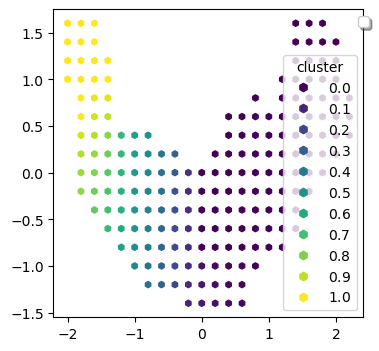

In [77]:
## plot committor
cm01 = committor_plus(T4, micro2clusters[[4,1,3]], micro2clusters[5])
fig, ax = plt.subplots(figsize=(4,4))
im = plt.scatter(micros['val0'],
                 micros['val1'], marker="h", s=20,
                 c=cm01, cmap=None)

legend1 = ax.legend(*im.legend_elements(), title="cluster")
ax.add_artist(legend1)
ax.legend(loc='upper center', bbox_to_anchor=(1, 1),
          ncol=3, fancybox=True, shadow=True)

#plt.xlabel('val0')
#plt.ylabel('val1')


In [115]:
print(micro2clusters)

[array([25, 35, 36, 42, 43, 44, 46, 50, 51, 52, 53, 54, 55, 59, 60, 61, 67,
       68]), array([ 86,  87,  88,  89,  90,  94,  95,  96,  97,  98, 103, 104, 105,
       106, 115, 116, 117, 118, 122, 123, 124, 125, 126, 128, 132, 133,
       140]), array([20, 32]), array([119, 120, 127, 129, 130, 131, 134, 135, 136, 137, 138, 139, 141,
       142, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 162,
       163]), array([148, 149, 156, 157, 158, 159, 160, 161, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190]), array([ 0,  1,  2,  3,  8,  9, 10, 11, 12, 13, 21, 22, 23, 24, 33, 34]), array([72, 73, 75, 78, 79, 80, 81, 82]), array([ 4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 26, 27, 28, 29, 30, 31, 37,
       38, 39, 40, 41, 45, 47]), array([ 48,  49,  56,  57,  58,  62,  63,  64,  65,  66,  69,  70,  71,
        74,  99, 107, 108, 109, 110, 121]), array([ 76,  77,  83,  84,  85,  91,  92, 

In [119]:
bound_states = np.concatenate([micro2clusters[i] for i in [1,3,4]])

In [120]:
out_states = np.concatenate([micro2clusters[i] for i in [2,5]])